In [1]:
import pickle
from sklearn.externals import joblib
import csv
import itertools
import operator
import numpy as np
import nltk
import sys
from datetime import datetime
from utils import *
import json
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os.path
from PIL import Image
import urllib
import shutil
#from RNNNumpy import RNNNumpy 
%matplotlib inline

unknown_token = "UNKNOWN_TOKEN"
sentence_start_token = "SENTENCE_START"
sentence_end_token = "SENTENCE_END"

In [2]:
class RNNNumpy:
    
    def __init__(self, word_dim, hidden_dim=100, bptt_truncate=4):
        # Assign instance variables
        self.word_dim = word_dim
        self.hidden_dim = hidden_dim
        self.bptt_truncate = bptt_truncate
        # Randomly initialize the network parameters
        self.U = np.random.uniform(-np.sqrt(1./word_dim), np.sqrt(1./word_dim), (hidden_dim, word_dim))
        self.V = np.random.uniform(-np.sqrt(1./hidden_dim), np.sqrt(1./hidden_dim), (word_dim, hidden_dim))
        self.W = np.random.uniform(-np.sqrt(1./hidden_dim), np.sqrt(1./hidden_dim), (hidden_dim, hidden_dim))
        
        
def forward_propagation(self, x):
    image_id = x[0]
    x = x[1]
    # The total number of time steps
    T = len(x)
    # During forward propagation we save all hidden states in s because need them later.
    # We add one additional element for the initial hidden, which we set to 0
    s = np.zeros((T + 1, self.hidden_dim))
    s[-1] = image_features[image_id] #np.zeros(self.hidden_dim)
    # The outputs at each time step. Again, we save them for later.
    o = np.zeros((T, self.word_dim))
    # For each time step...
    for t in np.arange(T):
        # Note that we are indxing U by x[t]. This is the same as multiplying U with a one-hot vector.
        s[t] = np.tanh(self.U[:,x[t]] + self.W.dot(s[t-1]))
        o[t] = softmax(self.V.dot(s[t]))
    return [o, s]

def predict(self, x):
    # Perform forward propagation and return index of the highest score
    o, s = self.forward_propagation(x)
    return np.argmax(o, axis=1)

def predict_image_caption(self, image_features, max_words = 15):
    x = []
    x.append(word_to_index[sentence_start_token]) #x[0] = start token
    
    s = np.zeros((max_words+1, self.hidden_dim))
    s[-1] = image_features
    
    # For each time step...
    for t in range(max_words):
        # Note that we are indxing U by x[t]. This is the same as multiplying U with a one-hot vector.
        s[t] = np.tanh(self.U[:,x[t]] + self.W.dot(s[t-1]))
        o = softmax(self.V.dot(s[t]))
        next_index = np.argmax(o)
#         #if it is the unknown token, take the next most probable word
#         if next_index == word_to_index[unknown_token]:
#             o[next_index] = 0
#             next_index = np.argmax(o)
        x.append(next_index)
        if index_to_word[next_index] == sentence_end_token:
            break
        
    sentence = []
    for index in x:
        sentence.append(index_to_word[index])
    return sentence
    
    
def calculate_total_loss(self, x, y):
    L = 0
    # For each sentence...
    for i in np.arange(len(y)):
        o, s = self.forward_propagation(x[i])
        # We only care about our prediction of the "correct" words
        correct_word_predictions = o[np.arange(len(y[i])), y[i]]
        # Add to the loss based on how off we were
        L += -1 * np.sum(np.log(correct_word_predictions))
    return L

def calculate_loss(self, x, y):
    # Divide the total loss by the number of training examples
    N = np.sum((len(y_i) for y_i in y))
    return self.calculate_total_loss(x,y)/N


def bptt(self, x, y):
    T = len(y)
    # Perform forward propagation
    o, s = self.forward_propagation(x)
    x = x[1]
    # We accumulate the gradients in these variables
    dLdU = np.zeros(self.U.shape)
    dLdV = np.zeros(self.V.shape)
    dLdW = np.zeros(self.W.shape)
    delta_o = o
    delta_o[np.arange(len(y)), y] -= 1.
    # For each output backwards...
    for t in np.arange(T)[::-1]:
        dLdV += np.outer(delta_o[t], s[t].T)
        # Initial delta calculation
        delta_t = self.V.T.dot(delta_o[t]) * (1 - (s[t] ** 2))
        # Backpropagation through time (for at most self.bptt_truncate steps)
        for bptt_step in np.arange(max(0, t-self.bptt_truncate), t+1)[::-1]:
            # print "Backpropagation step t=%d bptt step=%d " % (t, bptt_step)
            dLdW += np.outer(delta_t, s[bptt_step-1])              
            dLdU[:,x[bptt_step]] += delta_t
            # Update delta for next step
            delta_t = self.W.T.dot(delta_t) * (1 - s[bptt_step-1] ** 2)
    return [dLdU, dLdV, dLdW]


def gradient_check(self, x, y, h=0.001, error_threshold=0.01):
    # Calculate the gradients using backpropagation. We want to checker if these are correct.
    bptt_gradients = model.bptt(x, y)
    # List of all parameters we want to check.
    model_parameters = ['U', 'V', 'W']
    # Gradient check for each parameter
    for pidx, pname in enumerate(model_parameters):
        # Get the actual parameter value from the mode, e.g. model.W
        parameter = operator.attrgetter(pname)(self)
        print "Performing gradient check for parameter %s with size %d." % (pname, np.prod(parameter.shape))
        # Iterate over each element of the parameter matrix, e.g. (0,0), (0,1), ...
        it = np.nditer(parameter, flags=['multi_index'], op_flags=['readwrite'])
        while not it.finished:
            ix = it.multi_index
            # Save the original value so we can reset it later
            original_value = parameter[ix]
            # Estimate the gradient using (f(x+h) - f(x-h))/(2*h)
            parameter[ix] = original_value + h
            gradplus = model.calculate_total_loss([x],[y])
            parameter[ix] = original_value - h
            gradminus = model.calculate_total_loss([x],[y])
            estimated_gradient = (gradplus - gradminus)/(2*h)
            # Reset parameter to original value
            parameter[ix] = original_value
            # The gradient for this parameter calculated using backpropagation
            backprop_gradient = bptt_gradients[pidx][ix]
            # calculate The relative error: (|x - y|/(|x| + |y|))
            relative_error = np.abs(backprop_gradient - estimated_gradient)/(np.abs(backprop_gradient) + np.abs(estimated_gradient))
            # If the error is to large fail the gradient check
            if relative_error > error_threshold:
                print "Gradient Check ERROR: parameter=%s ix=%s" % (pname, ix)
                print "+h Loss: %f" % gradplus
                print "-h Loss: %f" % gradminus
                print "Estimated_gradient: %f" % estimated_gradient
                print "Backpropagation gradient: %f" % backprop_gradient
                print "Relative Error: %f" % relative_error
                return 
            it.iternext()
        print "Gradient check for parameter %s passed." % (pname)

        
# Performs one step of SGD.
def numpy_sdg_step(self, x, y, learning_rate):
    # Calculate the gradients
    dLdU, dLdV, dLdW = self.bptt(x, y)
    # Change parameters according to gradients and learning rate
    self.U -= learning_rate * dLdU
    self.V -= learning_rate * dLdV
    self.W -= learning_rate * dLdW
    
    
    
        

RNNNumpy.sgd_step = numpy_sdg_step
RNNNumpy.gradient_check = gradient_check
RNNNumpy.bptt = bptt
RNNNumpy.calculate_total_loss = calculate_total_loss
RNNNumpy.calculate_loss = calculate_loss
RNNNumpy.predict_image_caption = predict_image_caption
RNNNumpy.predict = predict
RNNNumpy.forward_propagation = forward_propagation

In [3]:
pca = joblib.load('pca.pkl')
    
all_image_features = np.load('C:\Users\Thanos\Documents\Python Scripts\Natural Language Processing 1\Image Captioning Project\merged_train.npy')
with open('C:\Users\Thanos\Documents\Python Scripts\Natural Language Processing 1\Image Captioning Project\merged_train.json') as f:
    all_image_captions = json.load(f)    
    
with open ('vocabulary.pkl', 'rb') as fp:
    index_to_word = pickle.load(fp)
    word_to_index = pickle.load(fp)
    
with open('model2.pkl', 'rb') as input:
    model = pickle.load(input)
    
with open('imageID_to_url.pkl', 'rb') as input:
    imageID_url = pickle.load(input)
    

In [4]:
print len(all_image_features[0])
print len(pca.transform([all_image_features[0]])[0])

4096
500


In [5]:
print model.hidden_dim
print model.word_dim

150
2000


In [6]:
print len(word_to_index)

2000


In [7]:
def get_image_features(image):
    return pca.transform([image])[0][:model.hidden_dim]


def get_image_caption(image):
    features = get_image_features(image)
    caption = model.predict_image_caption(features,30)
    caption = caption[1:-1]
    caption[0] = caption[0].capitalize()
    caption_str = " ".join(caption)
    return caption_str

In [26]:
test_i = 88812
generated_caption = get_image_caption(all_image_features[test_i])
print "Generated caption:"
print " ",generated_caption
print "True captions:"
for caption in all_image_captions[test_i][1]:
    print " "," ".join(caption)
print "Image ID: ", all_image_captions[test_i][0]

Generated caption:
  A woman in a kitchen with a pizza .
True captions:
  A family surrounding a little girl sitting at a table in front of a cake .
  An older man sits at a table with a baby in pigtails while a woman wearing glasses kneels next to her and a man takes a picture from the opposite side of the table .
  A family celebrating with gifts and a fancy cake
  A child with a woman holding her taking a photo
  A little girl and a woman are having their picture taken in front of a desert .
Image ID:  data/datasets/mscoco/val2014/COCO_val2014_000000222681.jpg


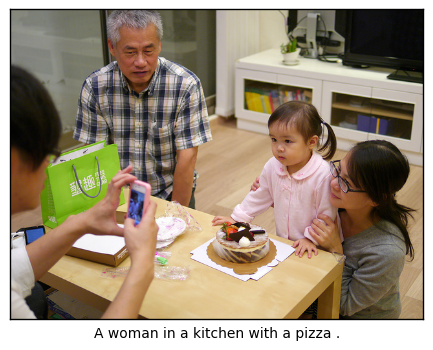

In [27]:
filename =  all_image_captions[test_i][0].split("/")[-1]

if not os.path.isfile("images/" + filename):
    urllib.urlretrieve(imageID_url[filename], "images/" + filename)
im = mpimg.imread("images/" + filename)
plt.xlabel(generated_caption) #jpgfile = Image.open("images/" + filename)

plt.xticks([]," ")
plt.yticks([]," ")
plt.imshow(im)

In [10]:
# import caffe
# help(caffe.Net) 